## Setup Python Environment

Install up the Python libraries

In [1]:
# Setup environment
#!apt-get -qq install xxd
!pip install pandas numpy matplotlib tensorflow

Defaulting to user installation because normal site-packages is not writeable


# Upload Data
Here I upload handshake ( this is not actually vibration, I simply hold the Arduino card and continously shaking it with large amplitude) and wind ( vibration mode on android application that I already sent in group discord)

# Graph Data (optional)

Plot the accelerometer measurements for the two corresponding classes.

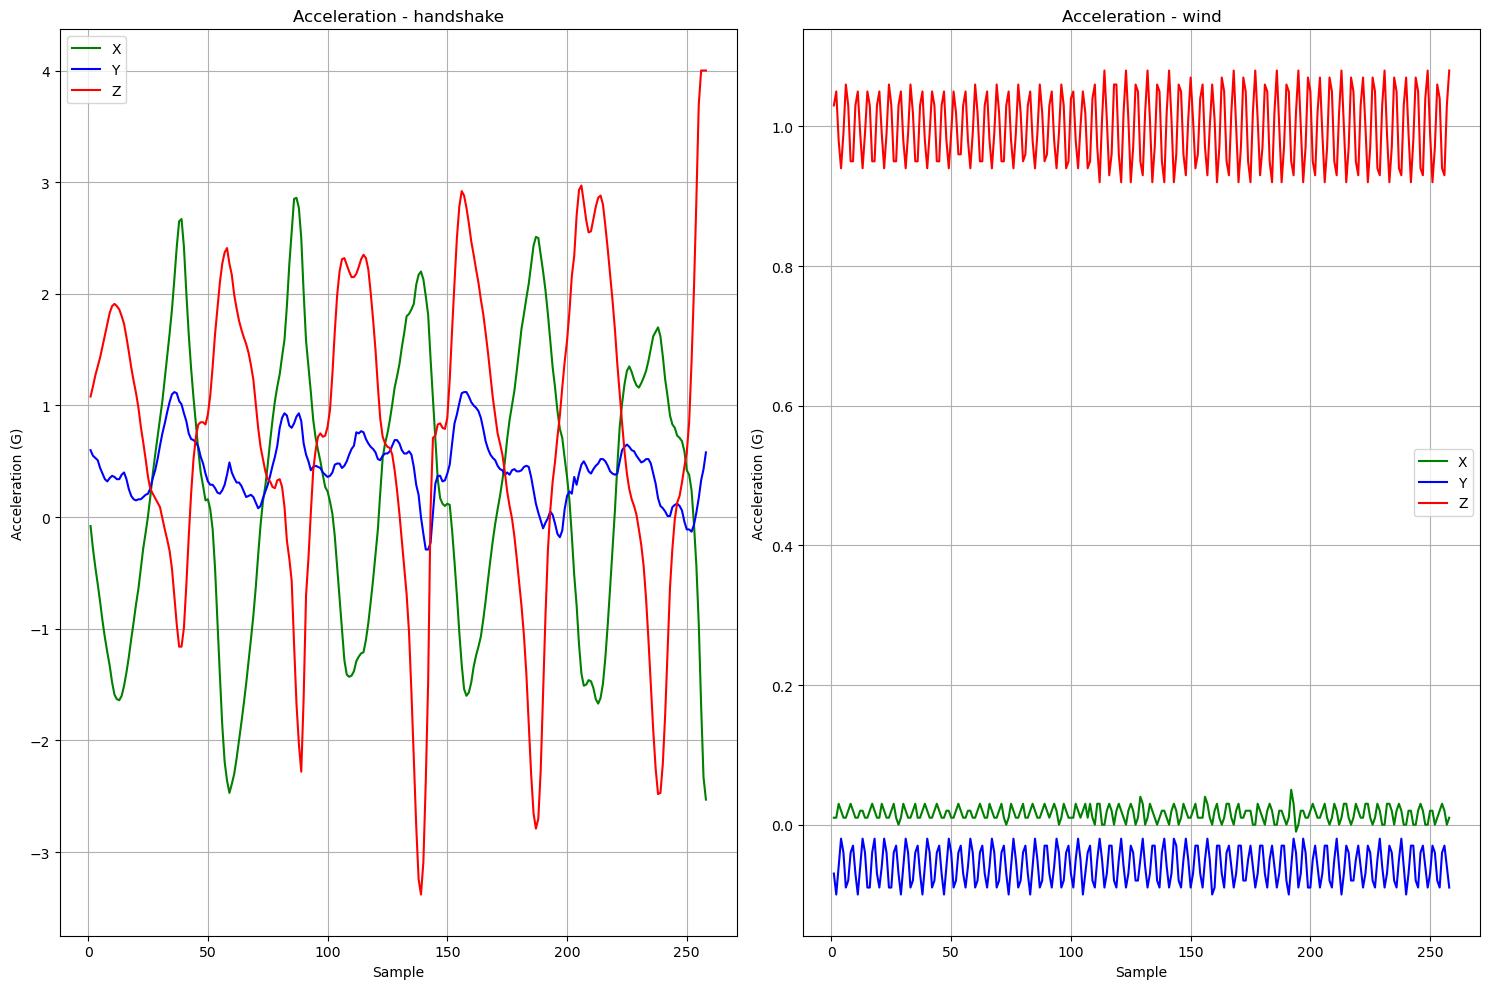

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# List of filenames and labels
datasets = {
    "handshake": "../dataset/handshake.csv",
    "wind": "../dataset/wind.csv"
}

def plot_data(num_points):
    plt.rcParams["figure.figsize"] = (15, 10)

    fig, axes = plt.subplots(1, 2, figsize=(15, 10)) 
    axes = axes.flatten()  

    for i, (label, filepath) in enumerate(datasets.items()):
        df = pd.read_csv(filepath)
        
        # Ensure we don't exceed available data points
        num_points = min(num_points, len(df))
        index = range(1, num_points + 1)

        # Plot X, Y, Z data
        axes[i].plot(index, df['X'][:num_points], 'g-', label='X')
        axes[i].plot(index, df['Y'][:num_points], 'b-', label='Y')
        axes[i].plot(index, df['Z'][:num_points], 'r-', label='Z')

        axes[i].set_title(f"Acceleration - {label}")
        axes[i].set_xlabel("Sample")
        axes[i].set_ylabel("Acceleration (G)")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Call the function 
plot_data(num_points=258)


# Train Neural Network





## Parse and prepare the data

Parse the CSV files and transforms them to a format that can be used to train the fully connected neural network.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of vibration modes
VIBRATION_MODES = [
    "handshake",
    "wind"
]

# I choosed this because with 258 samples we can distinguish between diffrent vibration modes quite clearly
SAMPLES_PER_VIBRATION_MODE = 258

NUM_VIBRATION_MODES = len(VIBRATION_MODES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_VIBRATION_MODES = np.eye(NUM_VIBRATION_MODES)

inputs = []
outputs = []

# read each csv file and push an input and output
for vibration_mode_index in range(NUM_VIBRATION_MODES):
  vibration_mode = VIBRATION_MODES[vibration_mode_index]
  print(f"Processing index {vibration_mode_index} for vibration mode '{vibration_mode}'.")

  output = ONE_HOT_ENCODED_VIBRATION_MODES[vibration_mode_index]

  # Construct the correct path
  filename = f"../dataset/{vibration_mode}.csv"

  # Read the CSV file
  df = pd.read_csv(filename)

  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)

  # calculate the number of vibration mode recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_VIBRATION_MODE)

  print(f"\tThere are {num_recordings} recordings of the {vibration_mode} vibration mode.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_VIBRATION_MODE):
      index = i * SAMPLES_PER_VIBRATION_MODE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      tensor += [
          (df['X'][index] + 4) / 8,
          (df['Y'][index] + 4) / 8,
          (df['Z'][index] + 4) / 8,
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.18.0

Processing index 0 for vibration mode 'handshake'.
	There are 55 recordings of the handshake vibration mode.
Processing index 1 for vibration mode 'wind'.
	There are 55 recordings of the wind vibration mode.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [5]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
# the final layer is softmax because we only expect one vibration mode to occur per input
model.add(tf.keras.layers.Dense(NUM_VIBRATION_MODES, activation='softmax'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=40, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2934 - mae: 0.4767 - val_loss: 0.2712 - val_mae: 0.4493
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2788 - mae: 0.5205 - val_loss: 0.2400 - val_mae: 0.4875
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2557 - mae: 0.5005 - val_loss: 0.2473 - val_mae: 0.4972
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2459 - mae: 0.4906 - val_loss: 0.2364 - val_mae: 0.4860
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2447 - mae: 0.4893 - val_loss: 0.2437 - val_mae: 0.4934
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2418 - mae: 0.4848 - val_loss: 0.2389 - val_mae: 0.4886
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2398 - mae: 0.4824 - val_loss: 0.2351 - val_mae: 0.4846
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2374 - mae: 0.4779 - val_loss: 0.2341 - val_mae: 0.4831
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2370 - mae: 

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving. Here it seems like my model is a little bit overfitting.

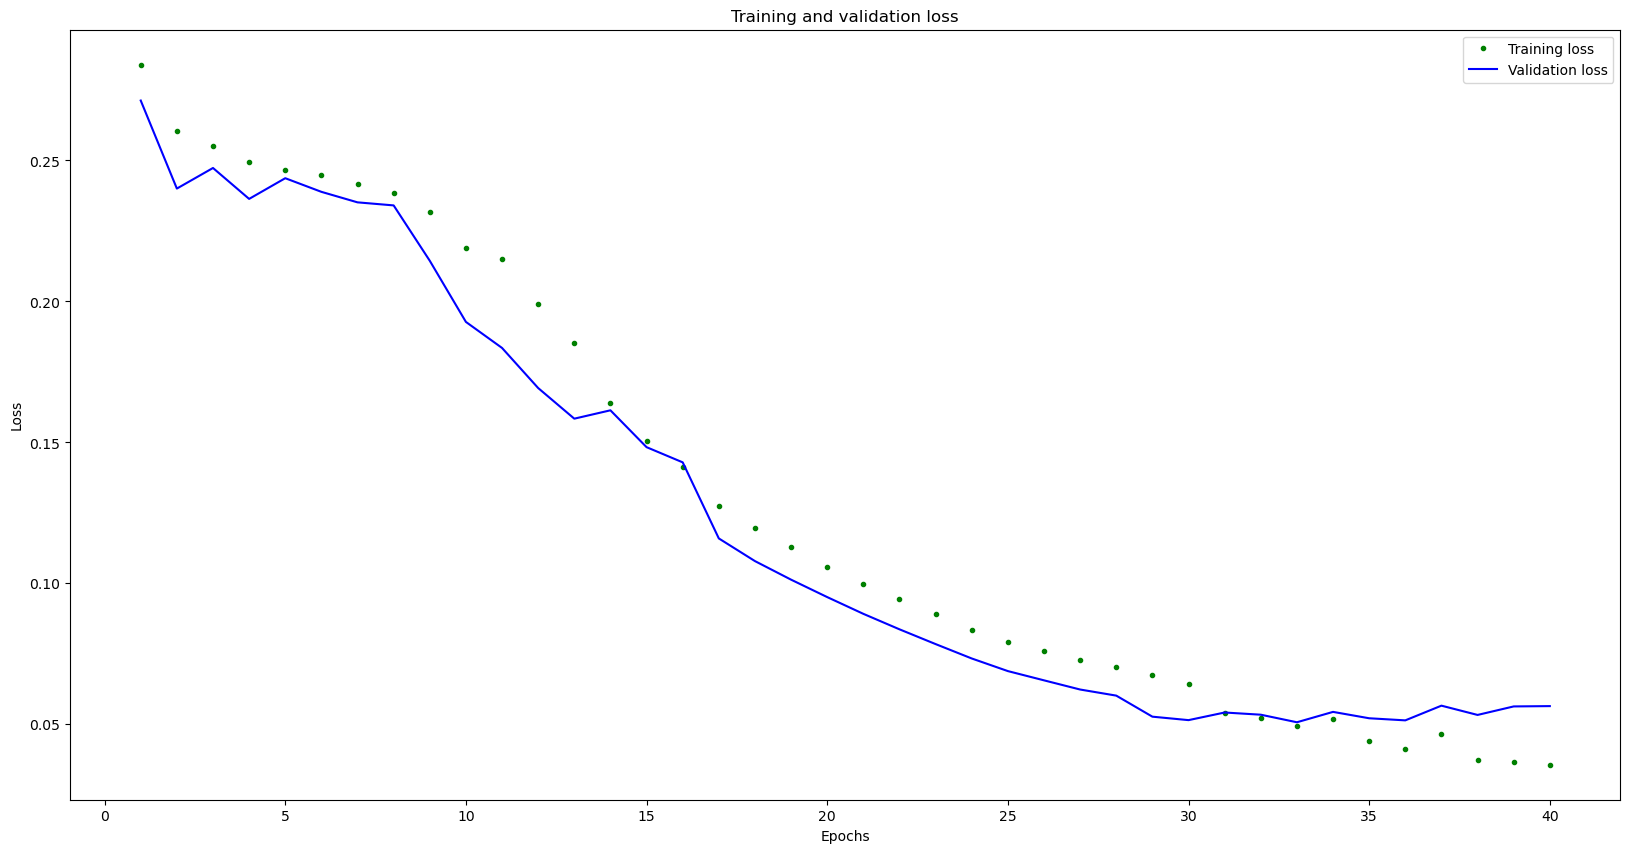

[20.0, 10.0]


In [6]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

## Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 20 so we can further zoom in once the model starts to converge.

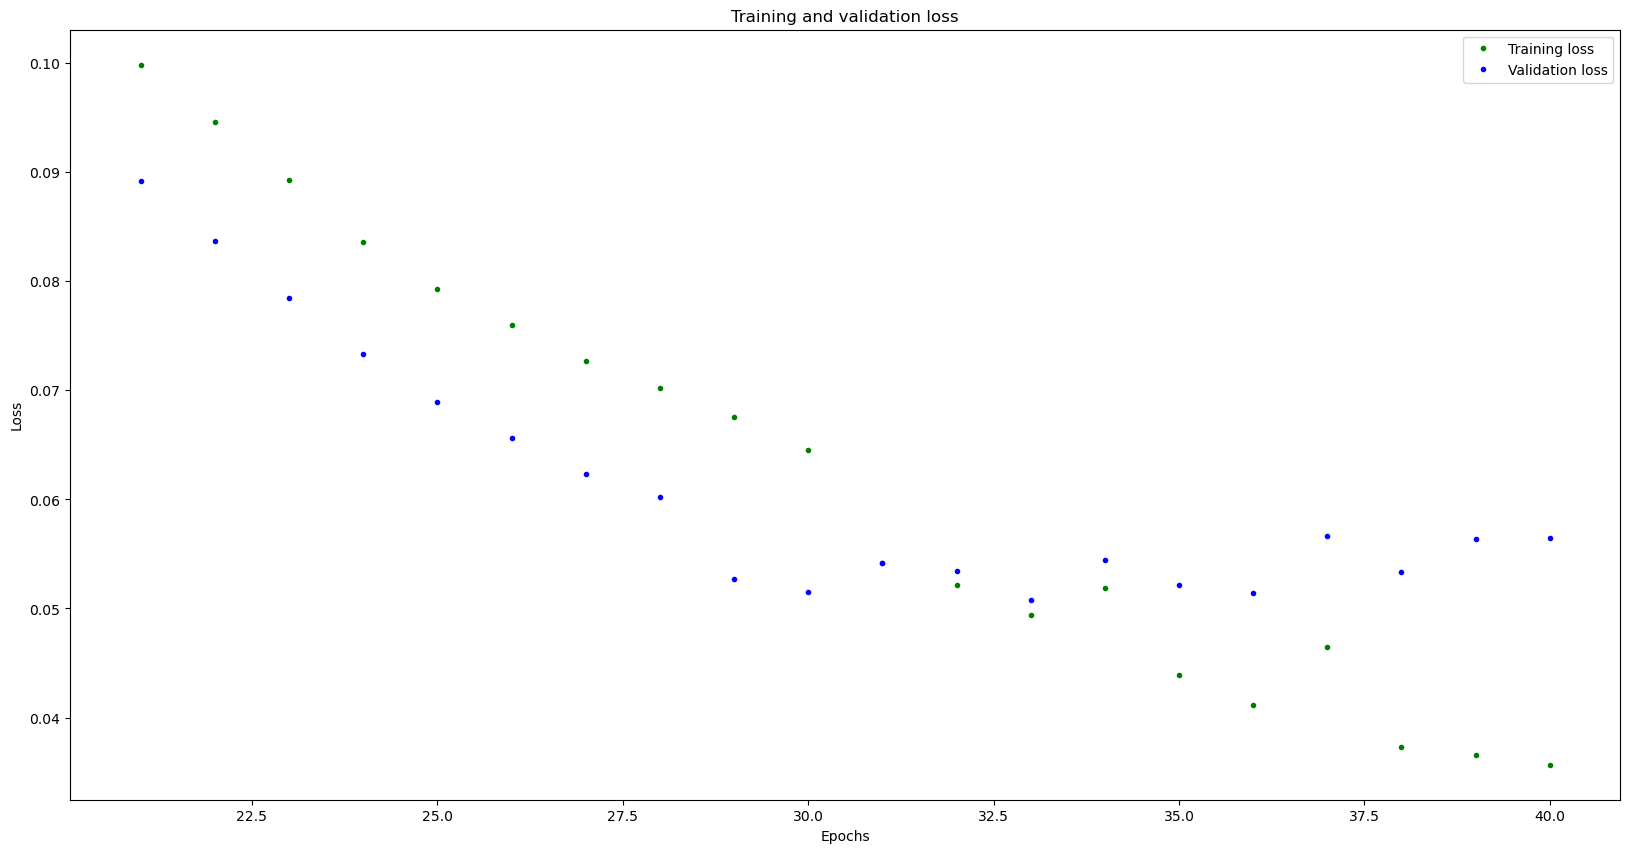

In [7]:
# graph the loss again skipping a bit of the start
SKIP = 20
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



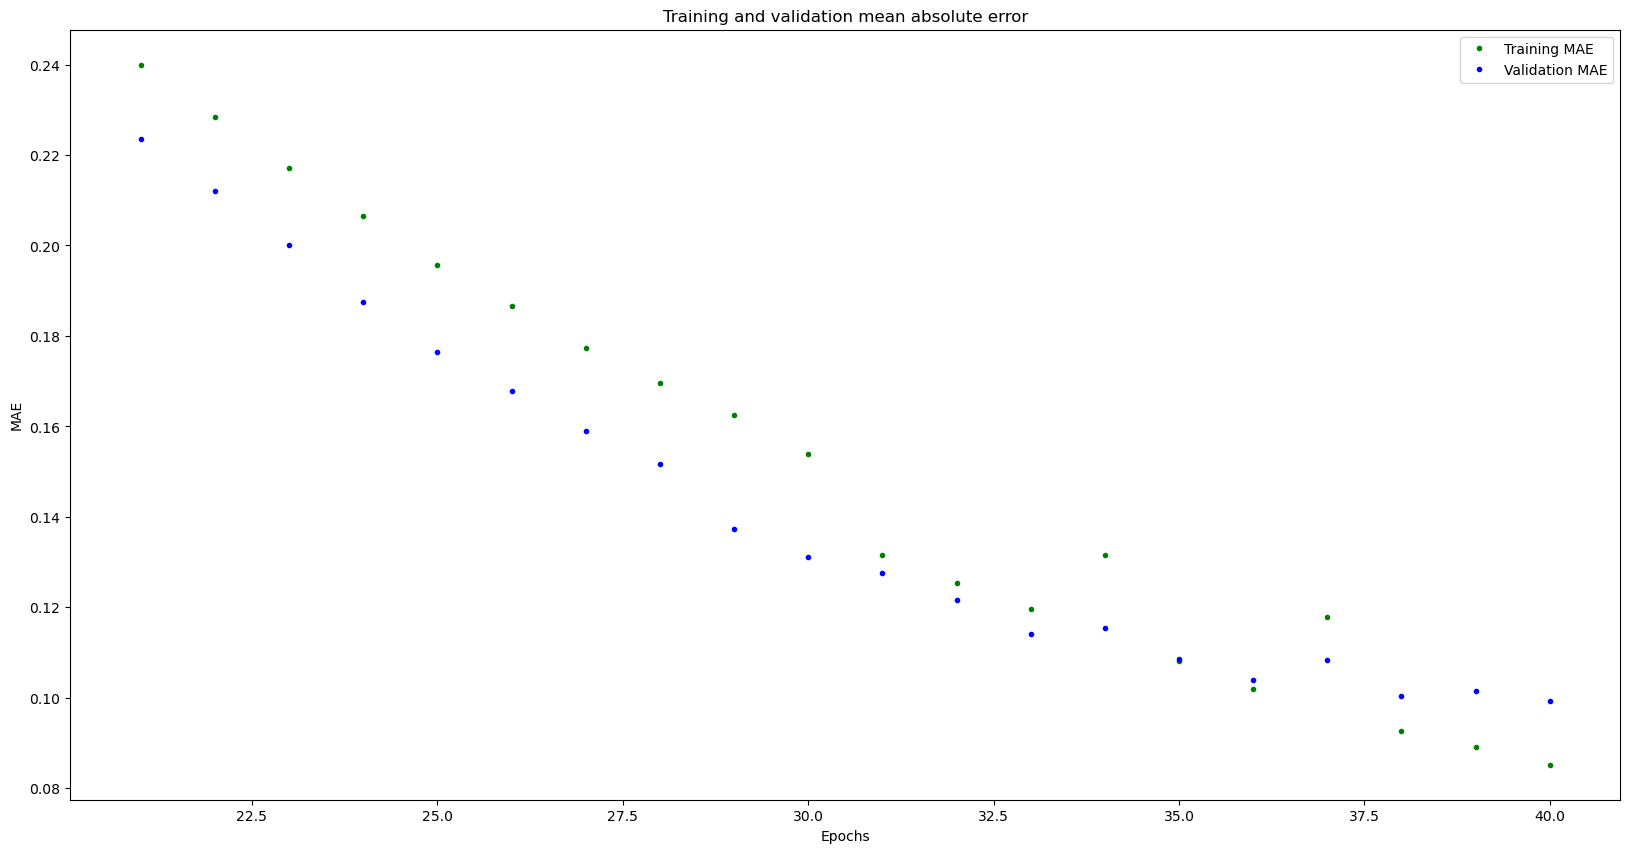

In [8]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and compare the predictions vs actual output


In [9]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
predictions =
 [[0.985 0.015]
 [0.992 0.008]
 [0.312 0.688]
 [0.024 0.976]
 [0.988 0.012]
 [0.024 0.976]
 [0.024 0.976]
 [0.024 0.976]
 [0.024 0.976]
 [0.024 0.976]
 [0.024 0.976]
 [0.024 0.976]
 [0.995 0.005]
 [0.724 0.276]
 [0.024 0.976]
 [0.025 0.975]
 [0.85  0.15 ]
 [0.024 0.976]
 [0.756 0.244]
 [0.025 0.975]
 [0.024 0.976]
 [0.024 0.976]]
actual =
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [10]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)



INFO:tensorflow:Assets written to: C:\Users\dangh\AppData\Local\Temp\tmping310rh\assets


INFO:tensorflow:Assets written to: C:\Users\dangh\AppData\Local\Temp\tmping310rh\assets


Saved artifact at 'C:\Users\dangh\AppData\Local\Temp\tmping310rh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 774), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(1, 2), dtype=tf.float32, name=None)
Captures:
  2331633696208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2331633696400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2331633696016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2331375908432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2331634304208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2331634305552: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 160188 bytes


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import the generated model.h file as a tab into your Arduino sketch.

In [11]:
import os

# Writes the first line (start of the C array)
with open("model.h", "w") as f:
    f.write('const unsigned char model[] __attribute__((aligned(4))) = {\n')

# Reads the .tflite file in binary and generates hex bytes
with open("gesture_model.tflite", "rb") as tflite_file:
    data = tflite_file.read()

hex_content = ", ".join(f"0x{b:02x}" for b in data)

# Adds the hex bytes to model.h
with open("model.h", "a") as f:
    f.write(hex_content)

# Closes the C array
with open("model.h", "a") as f:
    f.write('\n};\n')

# Displays the size of model.h
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")


Header file, model.h, is 961,193 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
